In [2]:
# !pip install opencv-python transformers accelerate insightface
import diffusers
from diffusers.utils import load_image
from diffusers.models import ControlNetModel

import cv2
import torch
import numpy as np
from PIL import Image

from insightface.app import FaceAnalysis
from pipeline_stable_diffusion_xl_instantid import StableDiffusionXLInstantIDPipeline, draw_kps

# prepare 'antelopev2' under ./models
app = FaceAnalysis(name='antelopev2', root='./', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# prepare models under ./checkpoints
face_adapter = f'./checkpoints/ip-adapter.bin'
controlnet_path = f'./checkpoints/ControlNetModel'

# load IdentityNet
controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)

base_model = 'wangqixun/YamerMIX_v8'  # from https://civitai.com/models/84040?modelVersionId=196039
pipe = StableDiffusionXLInstantIDPipeline.from_pretrained(
    base_model,
    controlnet=controlnet,
    torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload()
pipe.enable_vae_tiling()
# pipe.cuda()

# load adapter
pipe.load_ip_adapter_instantid(face_adapter)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


The config attributes {'controlnet_list': ['controlnet', 'RPMultiControlNetModel'], 'requires_aesthetics_score': False} were passed to StableDiffusionXLInstantIDPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'controlnet_list': ['controlnet', 'RPMultiControlNetModel'], 'requires_aesthetics_score': False} are not expected by StableDiffusionXLInstantIDPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


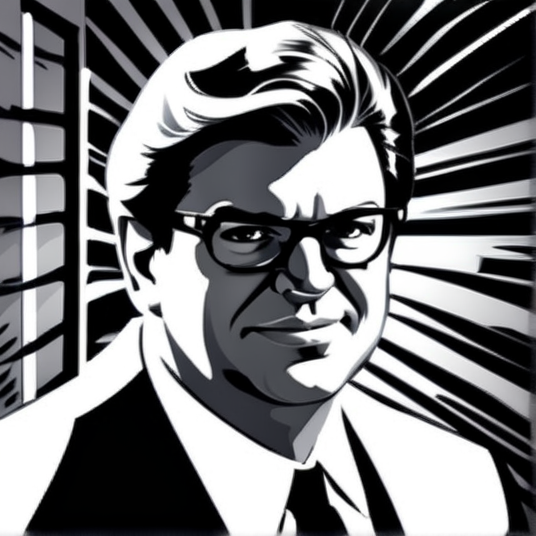

In [3]:
# load an image
face_image = load_image("./examples/yann-lecun_resize.jpg")

# prepare face emb
face_info = app.get(cv2.cvtColor(np.array(face_image), cv2.COLOR_RGB2BGR))
face_info = sorted(face_info, key=lambda x:(x['bbox'][2]-x['bbox'][0])*(x['bbox'][3]-x['bbox'][1]))[-1]  # only use the maximum face
face_emb = face_info['embedding']
face_kps = draw_kps(face_image, face_info['kps'])

# prompt
prompt = "film noir style, ink sketch|vector, male man, highly detailed, sharp focus, ultra sharpness, monochrome, high contrast, dramatic shadows, 1940s style, mysterious, cinematic"
negative_prompt = "ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, vibrant, colorful"

# generate image
image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image_embeds=face_emb,
    image=face_kps,
    controlnet_conditioning_scale=0.8,
    ip_adapter_scale=0.8,
).images[0]
image